# Motivation Figures: MATH Baseline Arrival Rate Sweep

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
})

# ── Load data ──
CSV_NAME = 'baseline_motivation_sweep_math_test_300_poisson.csv'
# Jupyter cwd can be repo root or `visualization/` depending on how it was launched.
_candidates = [
    Path('logs/motivation_plot_generator_data') / CSV_NAME,
    Path('..') / 'logs/motivation_plot_generator_data' / CSV_NAME,
]
for _p in _candidates:
    if _p.exists():
        DATA_PATH = _p
        break
else:
    raise FileNotFoundError(f'Could not find {CSV_NAME}. Tried: ' + ', '.join(str(p) for p in _candidates))

df = pd.read_csv(DATA_PATH)
print(f'Loaded CSV: {DATA_PATH.resolve()}')


# ── Filter to step-level records (per-LLM-call metrics) ──
step_df = df[df.record_type == 'step'].copy()
ep_df   = df[df.record_type == 'episode'].copy()

# ── Numeric coercion ──
for col in ['latency_seconds', 'arrival_rate', 'llm_running', 'llm_waiting',
            'llm_kv_cache_usage', 'observed_ttft', 'observed_tpot',
            'llm_ttft_avg', 'llm_itl_avg', 'llm_e2e_avg', 'llm_queue_avg', 'llm_inference_avg']:
    step_df[col] = pd.to_numeric(step_df[col], errors='coerce')

# ── Queue depth = running + waiting ──
step_df['queue_depth'] = step_df['llm_running'].fillna(0) + step_df['llm_waiting'].fillna(0)

# ── Short model names ──
model_name_map = {
    'Qwen/Qwen2.5-Coder-14B-Instruct':          'Qwen-14B',
    'mistralai/Mistral-Small-24B-Instruct-2501':  'Mistral-24B',
    'meta-llama/Llama-3.2-3B-Instruct':           'Llama-3B',
    'meta-llama/Llama-3.1-8B-Instruct':           'Llama-8B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B':   'DeepSeek-32B',
}
step_df['model_short'] = step_df['llm_name'].map(model_name_map)
step_df = step_df[step_df['model_short'].notna()].copy()

arrival_rates = sorted(step_df['arrival_rate'].dropna().unique())
model_order = ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
models_in_data = [m for m in model_order if m in step_df['model_short'].unique()]

# ── CONSISTENT COLOR MAPPING FOR ALL MODELS ──
# This ensures each model has the same color across all plots
MODEL_COLORS = {
    'Llama-3B': '#66c2a5',      # Teal
    'Llama-8B': '#fc8d62',      # Orange
    'Qwen-14B': '#8da0cb',      # Purple
    'Mistral-24B': '#e78ac3',   # Pink
    'DeepSeek-32B': '#a6d854',  # Lime green
}

# Helper function to get colors for a list of models
def get_model_colors(model_list):
    """Returns a list of colors for the given models in order."""
    return [MODEL_COLORS[m] for m in model_list if m in MODEL_COLORS]

print(f'Step-level LLM calls:  {len(step_df)}')
print(f'Episode records:       {len(ep_df)}')
print(f'Arrival rates:         {arrival_rates}')
print(f'Models:                {models_in_data}')
print(f'\nModel Color Mapping:')
for model in models_in_data:
    print(f'  {model}: {MODEL_COLORS[model]}')

Loaded CSV: /home/ahasan/projects/infra-mind/logs/motivation_plot_generator_data/baseline_motivation_sweep_math_test_300_poisson.csv
Step-level LLM calls:  6180
Episode records:       1200
Arrival rates:         [np.float64(2.0), np.float64(50.0), np.float64(300.0), np.float64(700.0)]
Models:                ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']

Model Color Mapping:
  Llama-3B: #66c2a5
  Llama-8B: #fc8d62
  Qwen-14B: #8da0cb
  Mistral-24B: #e78ac3
  DeepSeek-32B: #a6d854


REQUEST DISTRIBUTION PER LLM

Total LLM Calls: 6180

       Model  Total Requests  Percentage (%)
    Llama-3B            2547            41.2
    Llama-8B            2498            40.4
    Qwen-14B             386             6.2
 Mistral-24B             364             5.9
DeepSeek-32B             385             6.2

REQUESTS BY ARRIVAL RATE AND MODEL

model_short  Llama-3B  Llama-8B  Qwen-14B  Mistral-24B  DeepSeek-32B  Total
Rate 2            630       614       111           91            94   1540
Rate 50           643       609       108           90            90   1540
Rate 300          640       651        87           83            94   1555
Rate 700          634       624        80          100           107   1545
Total            2547      2498       386          364           385   6180


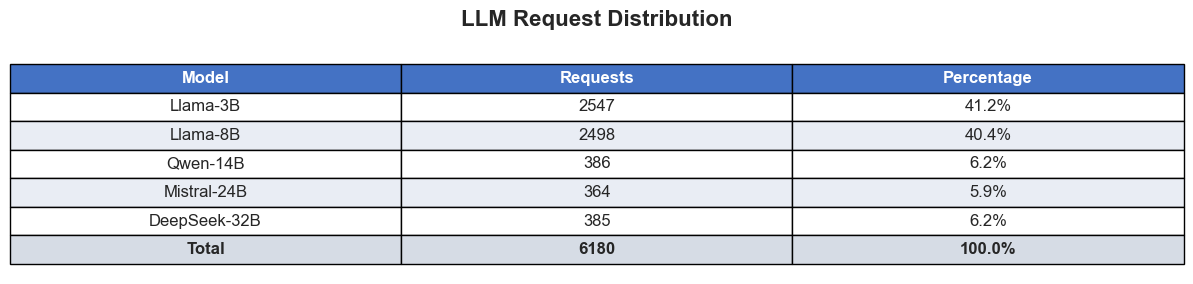

In [28]:
# ── Table: Request Distribution per LLM ──

# Count requests per model
request_counts = step_df['model_short'].value_counts().reindex(models_in_data)

# Count requests per model and arrival rate
request_by_rate = (
    step_df.groupby(['arrival_rate', 'model_short'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=models_in_data)
)

# Add total column and row
request_by_rate['Total'] = request_by_rate.sum(axis=1)
request_by_rate.loc['Total'] = request_by_rate.sum(axis=0)

# Calculate percentages
total_requests = len(step_df)
pct_by_model = (request_counts / total_requests * 100).round(1)

# Create summary table
summary_df = pd.DataFrame({
    'Model': models_in_data,
    'Total Requests': request_counts.values,
    'Percentage (%)': pct_by_model.values
})

print("=" * 60)
print("REQUEST DISTRIBUTION PER LLM")
print("=" * 60)
print(f"\nTotal LLM Calls: {total_requests}\n")

# Display summary table
print(summary_df.to_string(index=False))

print("\n" + "=" * 60)
print("REQUESTS BY ARRIVAL RATE AND MODEL")
print("=" * 60 + "\n")

# Format the index for display
request_by_rate_display = request_by_rate.copy()
request_by_rate_display.index = [f"Rate {int(r)}" if r != 'Total' else 'Total' for r in request_by_rate_display.index]
print(request_by_rate_display.to_string())

# Visual table using matplotlib
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('off')

# Create table data
table_data = [[m, int(c), f"{p:.1f}%"] for m, c, p in zip(models_in_data, request_counts.values, pct_by_model.values)]
table_data.append(['Total', total_requests, '100.0%'])

table = ax.table(
    cellText=table_data,
    colLabels=['Model', 'Requests', 'Percentage'],
    cellLoc='center',
    loc='center',
    colColours=['#4472C4'] * 3,
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8)

# Style header row
for j in range(3):
    table[(0, j)].set_text_props(color='white', fontweight='bold')

# Alternate row colors
for i in range(1, len(table_data) + 1):
    for j in range(3):
        if i == len(table_data):  # Total row
            table[(i, j)].set_facecolor('#D6DCE5')
            table[(i, j)].set_text_props(fontweight='bold')
        elif i % 2 == 0:
            table[(i, j)].set_facecolor('#E9EDF4')
        else:
            table[(i, j)].set_facecolor('#FFFFFF')

ax.set_title('LLM Request Distribution', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

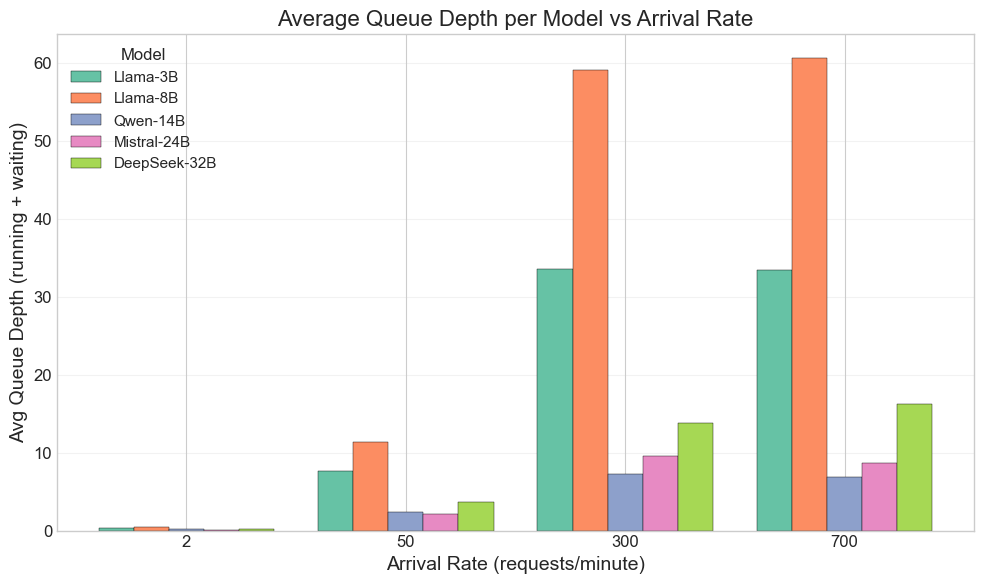

In [29]:
# ── Figure 1: Average Queue Depth per Model vs Arrival Rate ──
# Queue depth = llm_running + llm_waiting (vLLM metrics snapshot before each request)

queue_stats = (
    step_df.groupby(['arrival_rate', 'model_short'])['queue_depth']
    .mean()
    .reset_index()
)
queue_pivot = (
    queue_stats.pivot(index='arrival_rate', columns='model_short', values='queue_depth')
    .reindex(columns=models_in_data)
)

colors = get_model_colors(models_in_data)
x = np.arange(len(arrival_rates))
bar_width = 0.8 / max(len(models_in_data), 1)

fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models_in_data):
    offset = (i - (len(models_in_data) - 1) / 2) * bar_width
    ax.bar(
        x + offset,
        queue_pivot[model].values,
        width=bar_width,
        label=model,
        color=colors[i],
        edgecolor='black',
        linewidth=0.3,
    )

ax.set_xlabel('Arrival Rate (requests/minute)')
ax.set_ylabel('Avg Queue Depth (running + waiting)')
ax.set_title('Average Queue Depth per Model vs Arrival Rate')
ax.set_xticks(x)
ax.set_xticklabels([str(int(r)) for r in arrival_rates])
ax.legend(title='Model', loc='upper left')
ax.grid(True, axis='y', alpha=0.25)
plt.tight_layout()
plt.show()

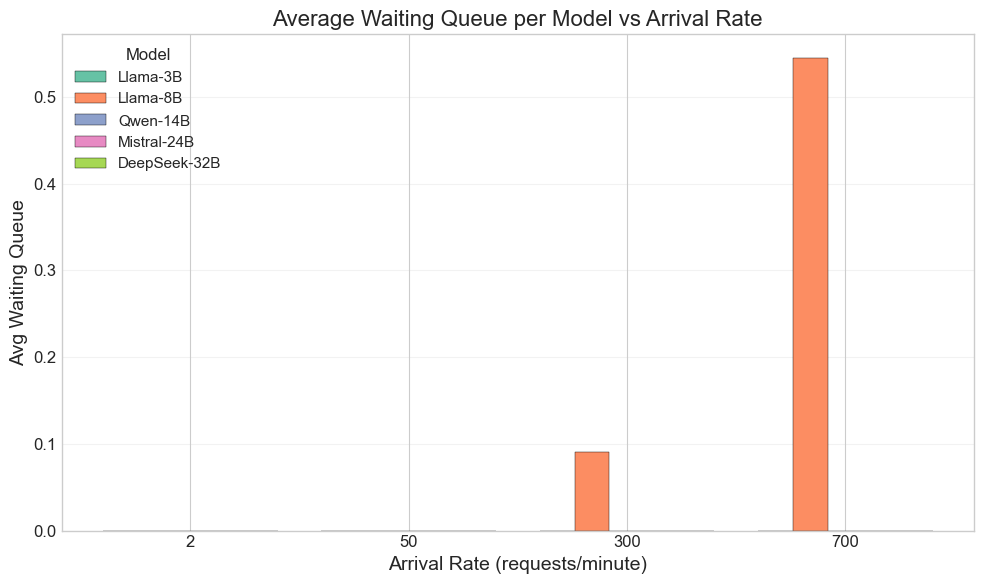

In [30]:
# ── Figure 1b: Average Waiting Queue per Model vs Arrival Rate ──
# Waiting queue = llm_waiting only (excludes currently running requests)

waiting_stats = (
    step_df.groupby(['arrival_rate', 'model_short'])['llm_waiting']
    .mean()
    .reset_index()
)
waiting_pivot = (
    waiting_stats.pivot(index='arrival_rate', columns='model_short', values='llm_waiting')
    .reindex(columns=models_in_data)
)

colors = get_model_colors(models_in_data)
x = np.arange(len(arrival_rates))
bar_width = 0.8 / max(len(models_in_data), 1)

fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models_in_data):
    offset = (i - (len(models_in_data) - 1) / 2) * bar_width
    ax.bar(
        x + offset,
        waiting_pivot[model].values,
        width=bar_width,
        label=model,
        color=colors[i],
        edgecolor='black',
        linewidth=0.3,
    )

ax.set_xlabel('Arrival Rate (requests/minute)')
ax.set_ylabel('Avg Waiting Queue')
ax.set_title('Average Waiting Queue per Model vs Arrival Rate')
ax.set_xticks(x)
ax.set_xticklabels([str(int(r)) for r in arrival_rates])
ax.legend(title='Model', loc='upper left')
ax.grid(True, axis='y', alpha=0.25)
plt.tight_layout()
plt.show()

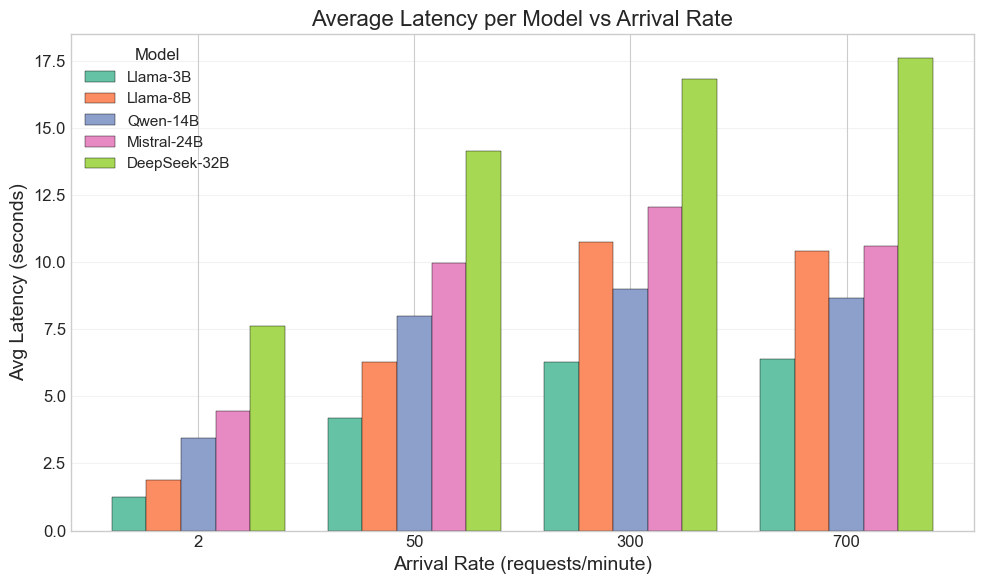

In [31]:
# ── Figure 2: Average Latency per Model vs Arrival Rate ──

latency_stats = (
    step_df.groupby(['arrival_rate', 'model_short'])['latency_seconds']
    .mean()
    .reset_index()
)
latency_pivot = (
    latency_stats.pivot(index='arrival_rate', columns='model_short', values='latency_seconds')
    .reindex(columns=models_in_data)
)

colors = get_model_colors(models_in_data)
x = np.arange(len(arrival_rates))
bar_width = 0.8 / max(len(models_in_data), 1)

fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models_in_data):
    offset = (i - (len(models_in_data) - 1) / 2) * bar_width
    vals = latency_pivot[model].values
    ax.bar(
        x + offset,
        vals,
        width=bar_width,
        label=model,
        color=colors[i],
        edgecolor='black',
        linewidth=0.3,
    )

ax.set_xlabel('Arrival Rate (requests/minute)')
ax.set_ylabel('Avg Latency (seconds)')
ax.set_title('Average Latency per Model vs Arrival Rate')
ax.set_xticks(x)
ax.set_xticklabels([str(int(r)) for r in arrival_rates])
ax.legend(title='Model', loc='upper left')
ax.grid(True, axis='y', alpha=0.25)
plt.tight_layout()
plt.show()

# Per-Role Latency vs Arrival Rate Plots

Found 12 unique roles: ['AlgorithmEngineer', 'CertifiedAccountant', 'Economist', 'Engineer', 'Inspector', 'MathAnalyst', 'MathSolver', 'MathTeacher', 'Mathematician', 'ProgrammingExpert', 'Scientist', 'SoftwareDeveloper']

Role: AlgorithmEngineer
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 122


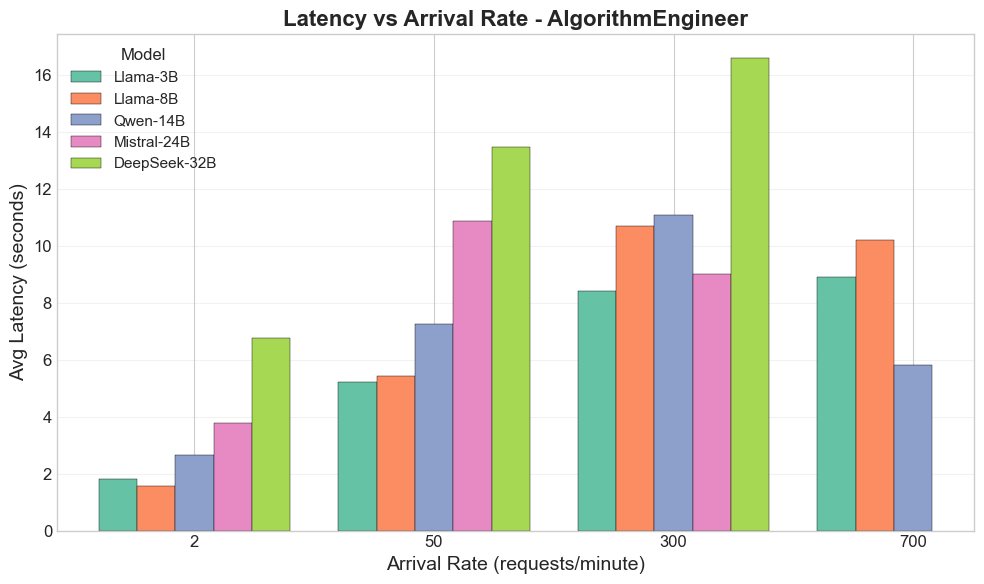


Role: CertifiedAccountant
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 443


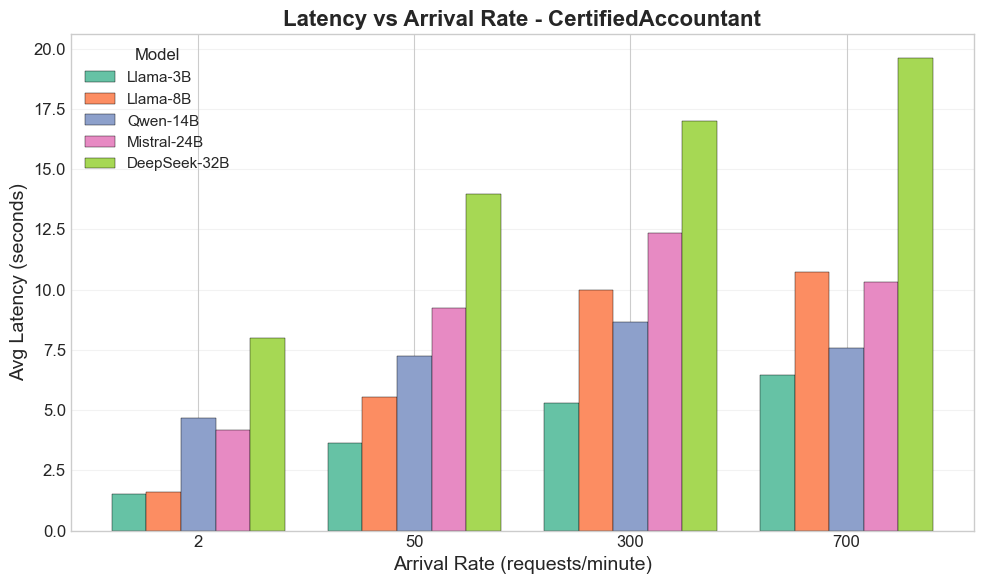


Role: Economist
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 1173


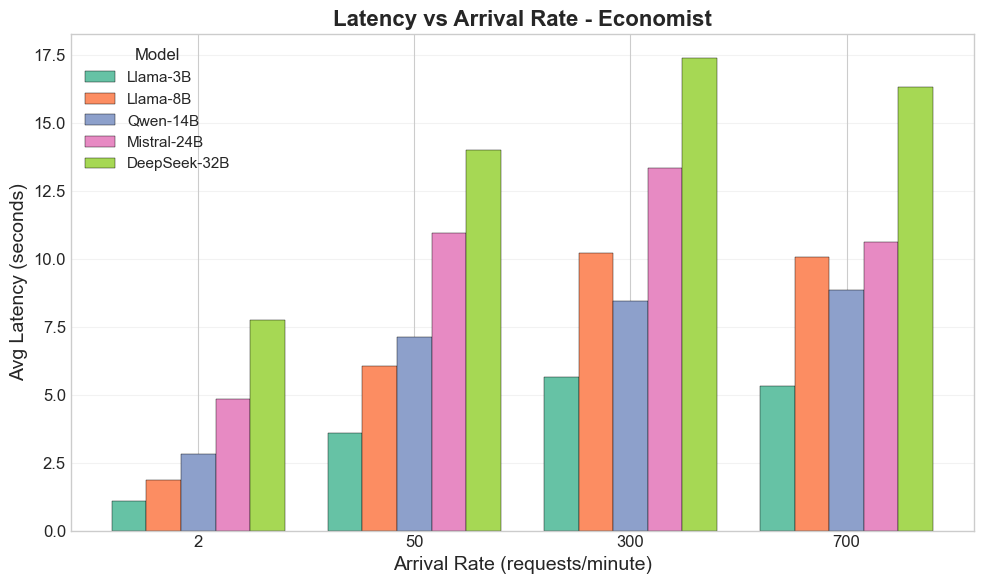


Role: Engineer
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 274


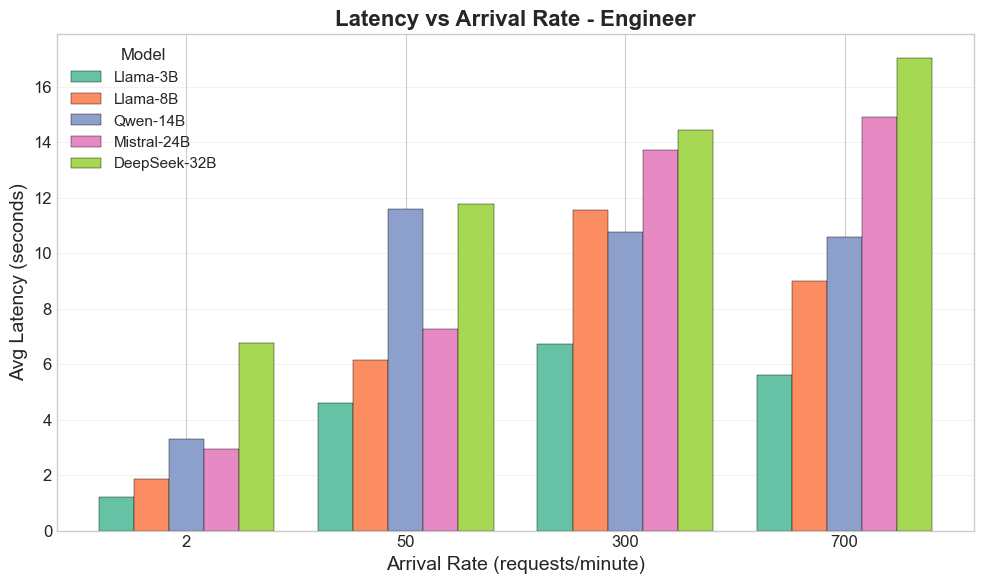


Role: Inspector
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 300


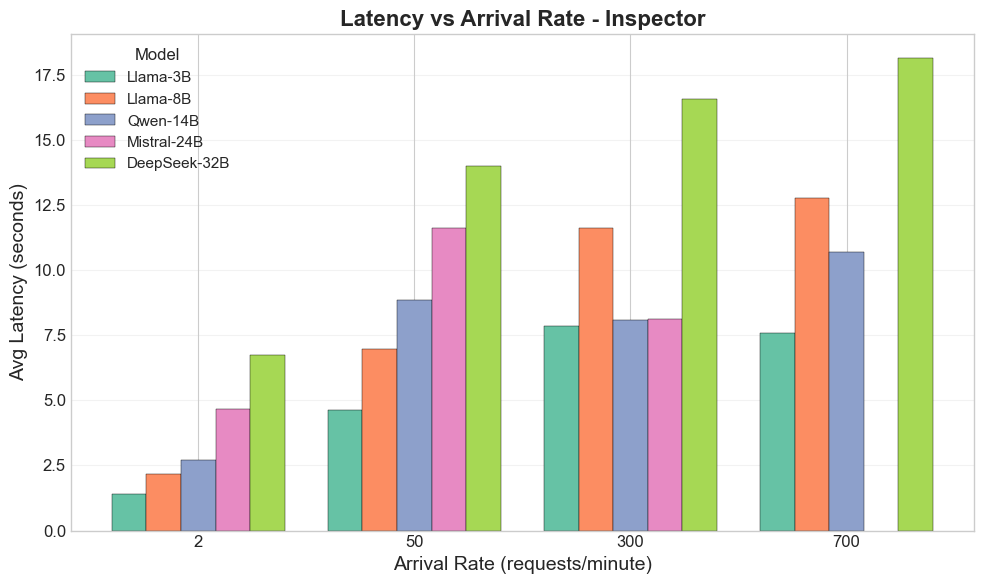


Role: MathAnalyst
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 579


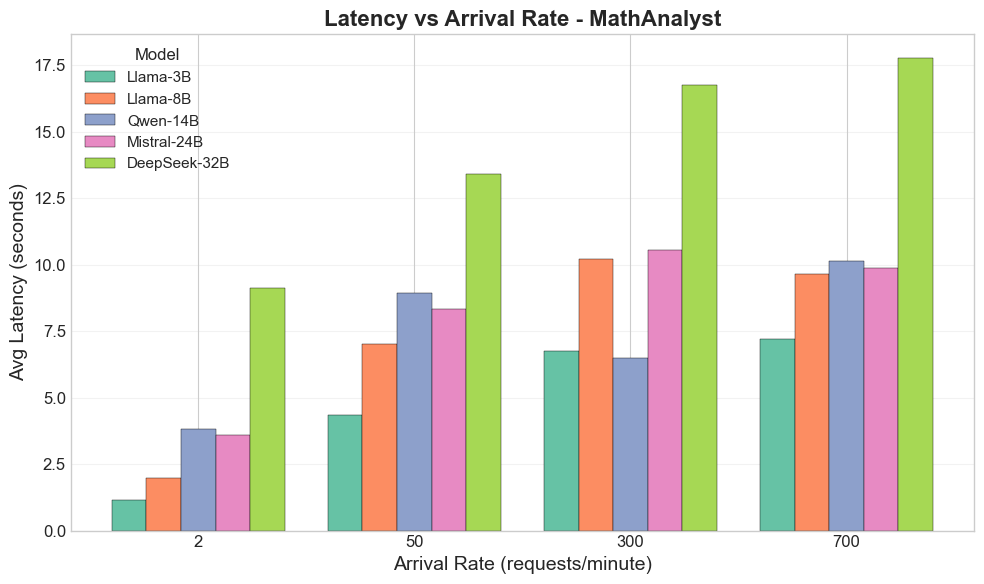


Role: MathSolver
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 1018


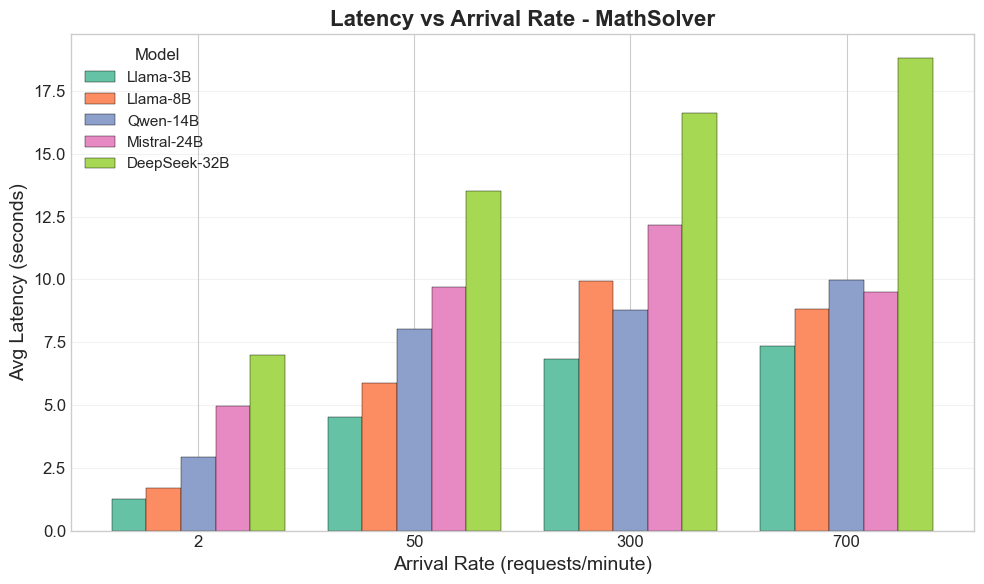


Role: MathTeacher
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 1065


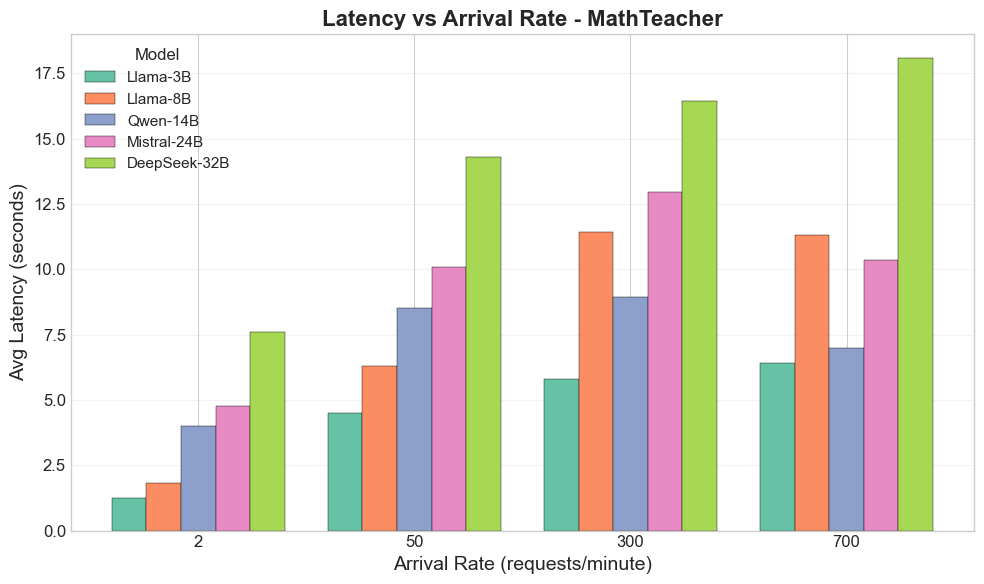


Role: Mathematician
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 807


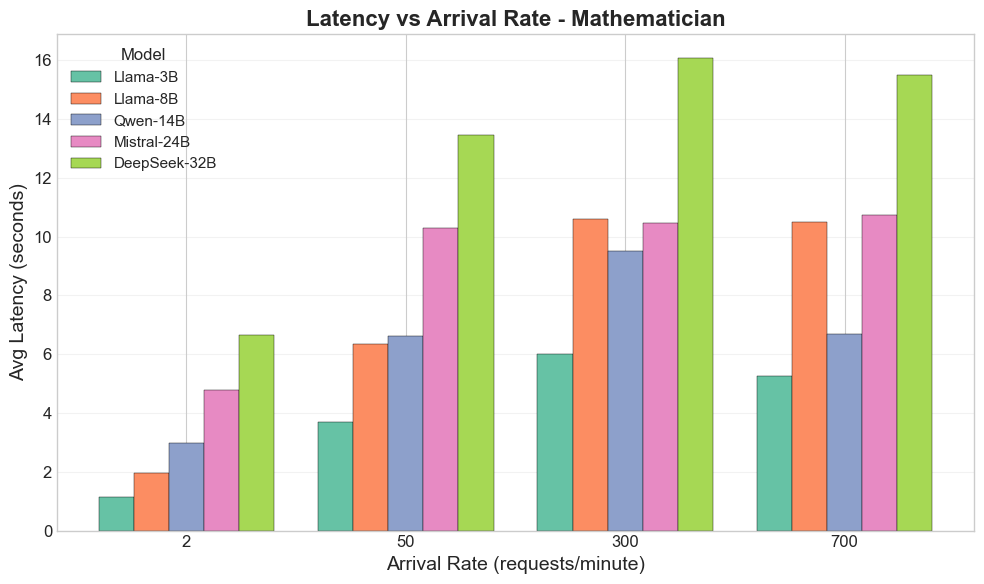


Role: ProgrammingExpert
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 96


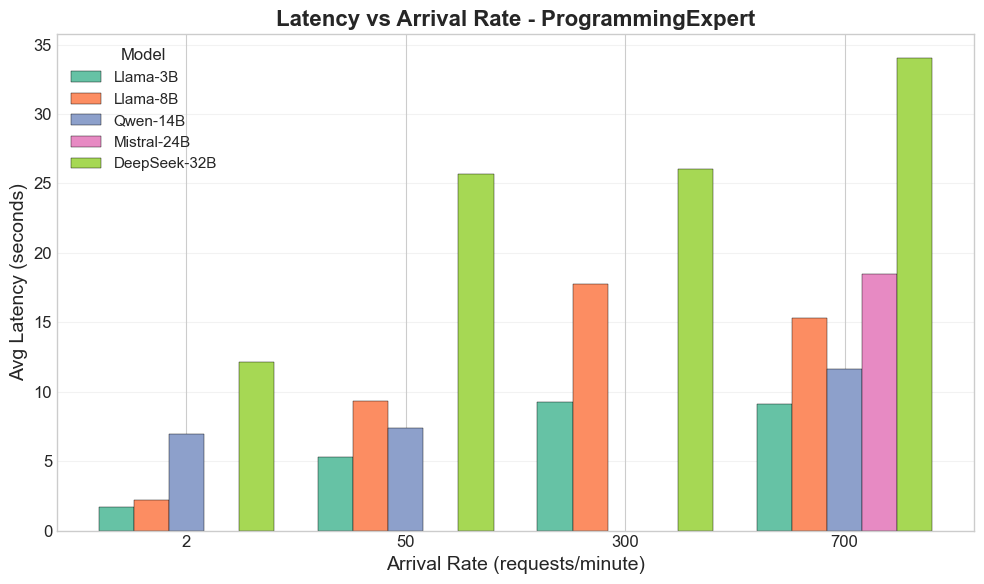


Role: Scientist
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 264


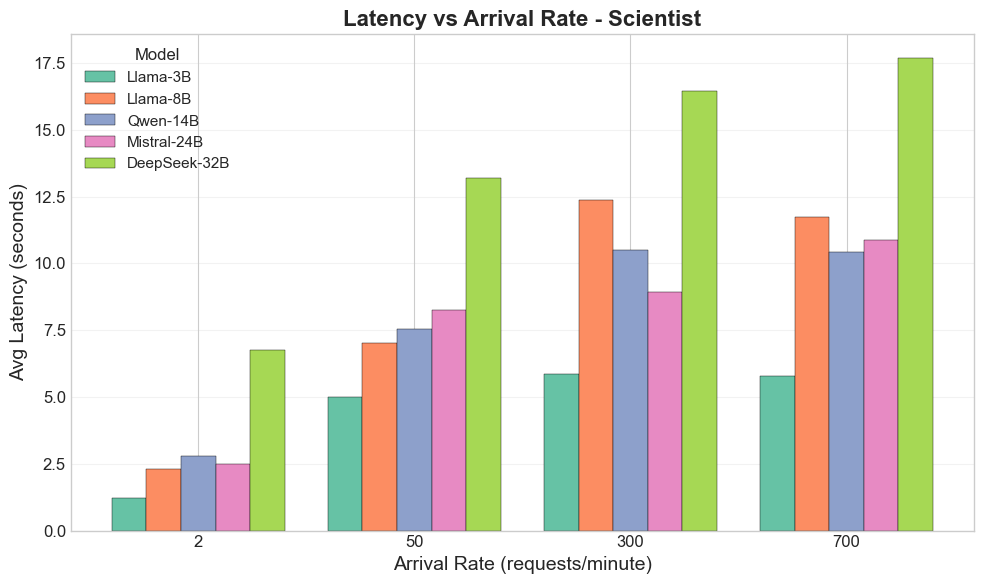


Role: SoftwareDeveloper
  Models: ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
  Data points: 39


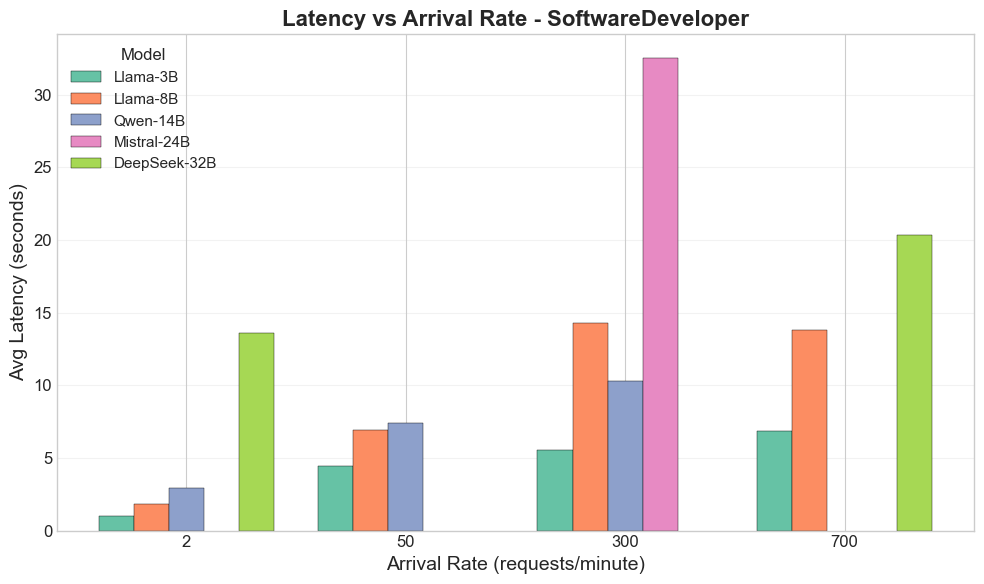

In [32]:
# ── Figure 3+: Average Latency vs Arrival Rate per Role ──
# Create one plot per role showing all models used with that role

# Get unique roles (excluding NaN)
roles = sorted([r for r in step_df['role_name'].dropna().unique() if pd.notna(r)])

print(f'Found {len(roles)} unique roles: {roles}\n')

# Generate one plot per role
for role in roles:
    # Filter data for this role
    role_df = step_df[step_df['role_name'] == role].copy()
    
    if len(role_df) == 0:
        print(f'No data for role: {role}')
        continue
    
    # Get models used with this role (preserve global order)
    role_models_set = set(role_df['model_short'].dropna().unique())
    role_models = [m for m in model_order if m in role_models_set]
    
    if len(role_models) == 0:
        print(f'No models found for role: {role}')
        continue
    
    print(f'Role: {role}')
    print(f'  Models: {role_models}')
    print(f'  Data points: {len(role_df)}')
    
    # Compute latency stats per model and arrival rate
    latency_stats = (
        role_df.groupby(['arrival_rate', 'model_short'])['latency_seconds']
        .mean()
        .reset_index()
    )
    
    # Create pivot table
    latency_pivot = (
        latency_stats.pivot(index='arrival_rate', columns='model_short', values='latency_seconds')
    )
    
    # Get arrival rates for this role
    role_arrival_rates = sorted(latency_pivot.index.dropna().unique())
    
    # Get consistent colors for these models
    colors = get_model_colors(role_models)
    x = np.arange(len(role_arrival_rates))
    bar_width = 0.8 / max(len(role_models), 1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, model in enumerate(role_models):
        if model not in latency_pivot.columns:
            continue
        offset = (i - (len(role_models) - 1) / 2) * bar_width
        vals = latency_pivot[model].values
        ax.bar(
            x + offset,
            vals,
            width=bar_width,
            label=model,
            color=colors[i],
            edgecolor='black',
            linewidth=0.3,
        )
    
    ax.set_xlabel('Arrival Rate (requests/minute)', fontsize=14)
    ax.set_ylabel('Avg Latency (seconds)', fontsize=14)
    ax.set_title(f'Latency vs Arrival Rate - {role}', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{int(r)}' for r in role_arrival_rates])
    ax.legend(title='Model', loc='upper left', fontsize=11)
    ax.grid(True, axis='y', alpha=0.25)
    plt.tight_layout()
    
    plt.show()
    print()

# Analysis: Queue Depth vs Latency Investigation

**Question**: Why does Llama have high queue depth but comparable latency to DeepSeek (which has lower queue)?

**Hypothesis**: Total latency = Queue Wait Time + Inference Time
- Smaller models (Llama) have fast inference but may accumulate queues
- Larger models (DeepSeek) have slow inference but fewer queued requests
- The net effect on total latency depends on the balance between these factors

In [33]:
# ── Analysis 1: Latency Components Breakdown ──
# Compare TTFT (time to first token) and inference time across models

print("=" * 80)
print("LATENCY COMPONENTS AT HIGH ARRIVAL RATE (300 req/min)")
print("=" * 80)
print()

# Filter to high arrival rate
high_rate = 300.0
high_rate_df = step_df[step_df['arrival_rate'] == high_rate].copy()

# Calculate statistics per model
for model in models_in_data:
    model_df = high_rate_df[high_rate_df['model_short'] == model]
    
    if len(model_df) == 0:
        continue
    
    # Metrics
    avg_latency = model_df['latency_seconds'].mean()
    avg_queue = model_df['queue_depth'].mean()
    avg_ttft = model_df['observed_ttft'].mean()
    avg_tpot = model_df['observed_tpot'].mean()
    avg_e2e = model_df['llm_e2e_avg'].mean()
    
    print(f"{model}:")
    print(f"  Avg Total Latency:     {avg_latency:.3f} s")
    print(f"  Avg Queue Depth:       {avg_queue:.2f}")
    print(f"  Avg TTFT (queuing):    {avg_ttft:.3f} s")
    print(f"  Avg TPOT (generation): {avg_tpot:.4f} s/token")
    print(f"  Avg E2E (from vLLM):   {avg_e2e:.3f} s")
    print(f"  Request Count:         {len(model_df)}")
    print()

print("\n" + "=" * 80)
print("KEY INSIGHT:")
print("=" * 80)
print("If Llama has high queue but low latency compared to DeepSeek:")
print("  → Llama processes requests FASTER (lower TPOT, faster E2E)")
print("  → Queue moves quickly despite being longer")
print("  → DeepSeek has slow processing, so even small queues cause delays")
print("=" * 80)

LATENCY COMPONENTS AT HIGH ARRIVAL RATE (300 req/min)

Llama-3B:
  Avg Total Latency:     6.268 s
  Avg Queue Depth:       33.60
  Avg TTFT (queuing):    0.395 s
  Avg TPOT (generation): 0.0321 s/token
  Avg E2E (from vLLM):   3.975 s
  Request Count:         640

Llama-8B:
  Avg Total Latency:     10.770 s
  Avg Queue Depth:       59.12
  Avg TTFT (queuing):    0.472 s
  Avg TPOT (generation): 0.0467 s/token
  Avg E2E (from vLLM):   7.148 s
  Request Count:         651

Qwen-14B:
  Avg Total Latency:     9.000 s
  Avg Queue Depth:       7.28
  Avg TTFT (queuing):    0.330 s
  Avg TPOT (generation): 0.0393 s/token
  Avg E2E (from vLLM):   7.642 s
  Request Count:         87

Mistral-24B:
  Avg Total Latency:     12.074 s
  Avg Queue Depth:       9.54
  Avg TTFT (queuing):    0.446 s
  Avg TPOT (generation): 0.0586 s/token
  Avg E2E (from vLLM):   9.153 s
  Request Count:         83

DeepSeek-32B:
  Avg Total Latency:     16.810 s
  Avg Queue Depth:       13.85
  Avg TTFT (queuing):    

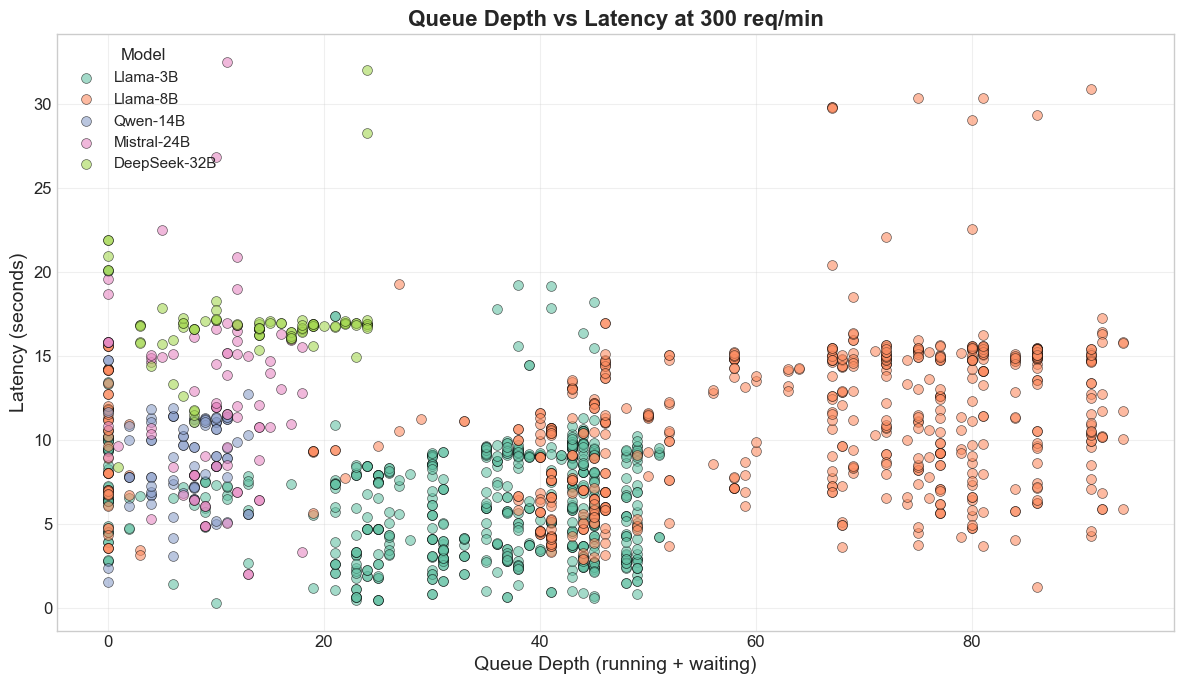

INTERPRETATION:
  - If points cluster horizontally: latency doesn't increase much with queue
  - If points trend upward-right: higher queue = higher latency
  - Compare vertical positions: models with higher base latency


In [34]:
# ── Analysis 2: Queue Depth vs Latency Scatter Plot ──
# Visualize the relationship between queue depth and observed latency

fig, ax = plt.subplots(figsize=(12, 7))

# Plot for each model at high arrival rate
for model in models_in_data:
    model_df = high_rate_df[high_rate_df['model_short'] == model]
    
    if len(model_df) == 0:
        continue
    
    ax.scatter(
        model_df['queue_depth'],
        model_df['latency_seconds'],
        label=model,
        color=MODEL_COLORS[model],
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Queue Depth (running + waiting)', fontsize=14)
ax.set_ylabel('Latency (seconds)', fontsize=14)
ax.set_title(f'Queue Depth vs Latency at {int(high_rate)} req/min', fontsize=16, fontweight='bold')
ax.legend(title='Model', loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print("  - If points cluster horizontally: latency doesn't increase much with queue")
print("  - If points trend upward-right: higher queue = higher latency")
print("  - Compare vertical positions: models with higher base latency")

In [35]:
# ── Analysis 3: Model Efficiency Comparison ──
# Calculate throughput and queue efficiency metrics

print("=" * 80)
print("MODEL EFFICIENCY METRICS AT HIGH ARRIVAL RATE (300 req/min)")
print("=" * 80)
print()

efficiency_data = []

for model in models_in_data:
    model_df = high_rate_df[high_rate_df['model_short'] == model]
    
    if len(model_df) == 0:
        continue
    
    # Calculate metrics
    avg_latency = model_df['latency_seconds'].mean()
    avg_queue = model_df['queue_depth'].mean()
    avg_e2e = model_df['llm_e2e_avg'].mean()
    request_count = len(model_df)
    
    # Throughput estimate: requests processed / average time per request
    # This is a rough estimate based on observed data
    throughput_estimate = 1.0 / avg_e2e if avg_e2e > 0 else 0
    
    # Queue efficiency: lower is better (less queue per unit latency)
    queue_efficiency = avg_queue / avg_latency if avg_latency > 0 else 0
    
    efficiency_data.append({
        'Model': model,
        'Avg Latency (s)': avg_latency,
        'Avg Queue Depth': avg_queue,
        'Avg E2E Time (s)': avg_e2e,
        'Est. Throughput (req/s)': throughput_estimate,
        'Queue/Latency Ratio': queue_efficiency,
        'Request Count': request_count
    })
    
    print(f"{model}:")
    print(f"  Avg Latency:           {avg_latency:.3f} s")
    print(f"  Avg Queue Depth:       {avg_queue:.2f}")
    print(f"  Avg E2E Time:          {avg_e2e:.3f} s")
    print(f"  Est. Throughput:       {throughput_estimate:.2f} req/s")
    print(f"  Queue/Latency Ratio:   {queue_efficiency:.2f}")
    print(f"  Request Count:         {request_count}")
    print()

print("=" * 80)
print("KEY FINDINGS:")
print("=" * 80)
print("• Higher Throughput = Model can process more requests per second")
print("• Lower Queue/Latency Ratio = Model handles queue more efficiently")
print("• Smaller models typically have higher throughput despite longer queues")
print("=" * 80)

# Create efficiency comparison dataframe
eff_df = pd.DataFrame(efficiency_data)
print("\n", eff_df.to_string(index=False))

MODEL EFFICIENCY METRICS AT HIGH ARRIVAL RATE (300 req/min)

Llama-3B:
  Avg Latency:           6.268 s
  Avg Queue Depth:       33.60
  Avg E2E Time:          3.975 s
  Est. Throughput:       0.25 req/s
  Queue/Latency Ratio:   5.36
  Request Count:         640

Llama-8B:
  Avg Latency:           10.770 s
  Avg Queue Depth:       59.12
  Avg E2E Time:          7.148 s
  Est. Throughput:       0.14 req/s
  Queue/Latency Ratio:   5.49
  Request Count:         651

Qwen-14B:
  Avg Latency:           9.000 s
  Avg Queue Depth:       7.28
  Avg E2E Time:          7.642 s
  Est. Throughput:       0.13 req/s
  Queue/Latency Ratio:   0.81
  Request Count:         87

Mistral-24B:
  Avg Latency:           12.074 s
  Avg Queue Depth:       9.54
  Avg E2E Time:          9.153 s
  Est. Throughput:       0.11 req/s
  Queue/Latency Ratio:   0.79
  Request Count:         83

DeepSeek-32B:
  Avg Latency:           16.810 s
  Avg Queue Depth:       13.85
  Avg E2E Time:          11.496 s
  Est. Throug

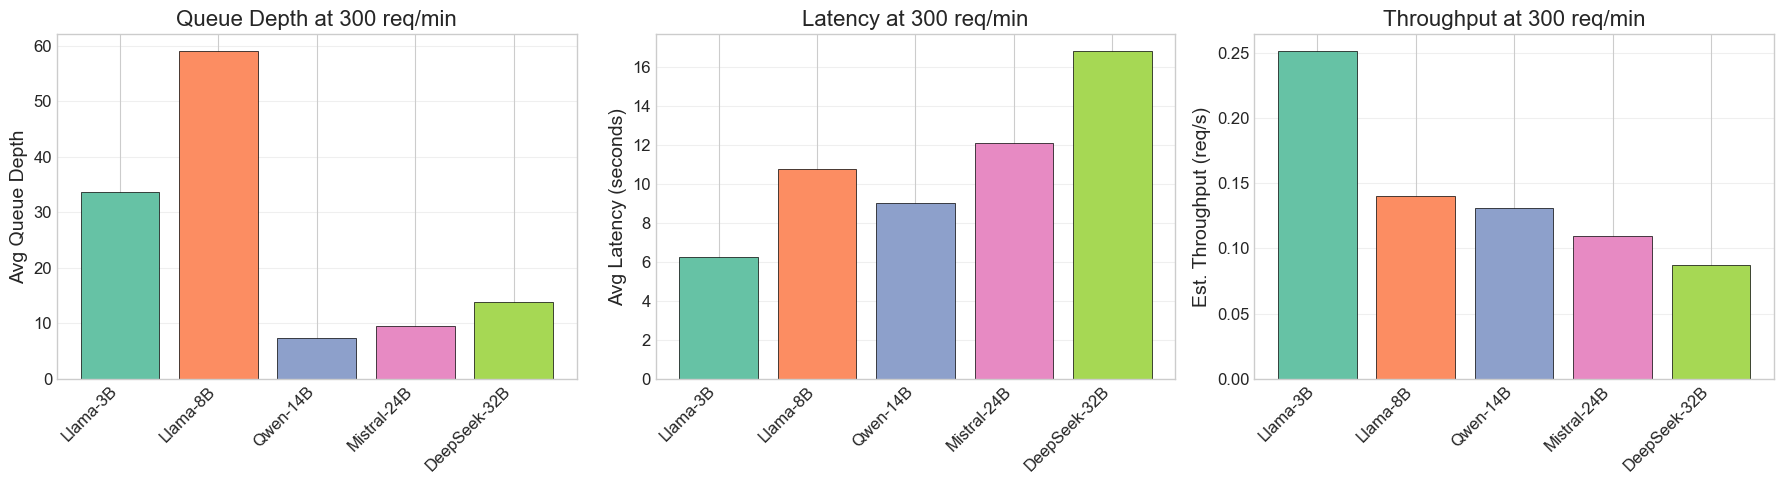


KEY OBSERVATION:
Notice the relationship between these three metrics:
  • Models with HIGH throughput can handle LONG queues efficiently
  • Models with LOW throughput accumulate less queue but have HIGH latency
  • Total latency depends on BOTH queue wait time AND processing speed

EXAMPLE:
  • Llama-3B: High queue BUT fast processing = Moderate total latency
  • DeepSeek-32B: Low queue BUT slow processing = High total latency


In [36]:
# ── Analysis 4: Side-by-Side Comparison at High Load ──
# Compare Queue Depth vs Latency vs Throughput

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Extract data for plotting
plot_models = [d['Model'] for d in efficiency_data]
plot_colors = get_model_colors(plot_models)

# Plot 1: Queue Depth
axes[0].bar(range(len(plot_models)), 
            [d['Avg Queue Depth'] for d in efficiency_data],
            color=plot_colors, edgecolor='black', linewidth=0.5)
axes[0].set_xticks(range(len(plot_models)))
axes[0].set_xticklabels(plot_models, rotation=45, ha='right')
axes[0].set_ylabel('Avg Queue Depth')
axes[0].set_title('Queue Depth at 300 req/min')
axes[0].grid(True, axis='y', alpha=0.3)

# Plot 2: Latency
axes[1].bar(range(len(plot_models)), 
            [d['Avg Latency (s)'] for d in efficiency_data],
            color=plot_colors, edgecolor='black', linewidth=0.5)
axes[1].set_xticks(range(len(plot_models)))
axes[1].set_xticklabels(plot_models, rotation=45, ha='right')
axes[1].set_ylabel('Avg Latency (seconds)')
axes[1].set_title('Latency at 300 req/min')
axes[1].grid(True, axis='y', alpha=0.3)

# Plot 3: Throughput
axes[2].bar(range(len(plot_models)), 
            [d['Est. Throughput (req/s)'] for d in efficiency_data],
            color=plot_colors, edgecolor='black', linewidth=0.5)
axes[2].set_xticks(range(len(plot_models)))
axes[2].set_xticklabels(plot_models, rotation=45, ha='right')
axes[2].set_ylabel('Est. Throughput (req/s)')
axes[2].set_title('Throughput at 300 req/min')
axes[2].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKEY OBSERVATION:")
print("=" * 80)
print("Notice the relationship between these three metrics:")
print("  • Models with HIGH throughput can handle LONG queues efficiently")
print("  • Models with LOW throughput accumulate less queue but have HIGH latency")
print("  • Total latency depends on BOTH queue wait time AND processing speed")
print()
print("EXAMPLE:")
print("  • Llama-3B: High queue BUT fast processing = Moderate total latency")
print("  • DeepSeek-32B: Low queue BUT slow processing = High total latency")
print("=" * 80)